In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVR, SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from patsy import dmatrices

In [2]:
time_diary = pd.read_stata("C:/Users/39348/Downloads/data/td_ita.dta")
questionnaire = pd.read_stata("C:/Users/39348/Downloads/data/data4diarynew_ITA.dta")

In [3]:
# Define the cutoff date and time
cutoff_datetime = pd.to_datetime("2020-11-30 11:00:00")
cutoff_datetime2 = pd.to_datetime("2020-11-14 4:30:00")

# Filter the DataFrame to keep only rows where 'date_not' is earlier than the cutoff
time_diary = time_diary[time_diary['date_not'] < cutoff_datetime]
time_diary = time_diary[time_diary['date_not'] > cutoff_datetime2]

# Display the result to verify that all later dates have been removed
print(time_diary.date_not.head(1).item())
print(time_diary.date_not.tail(1).item())

2020-11-14 05:00:00
2020-11-30 10:00:00


In [4]:
# Convert 'date_not' to datetime if it's not already
time_diary['date_not'] = pd.to_datetime(time_diary['date_not'])

# Shift 'date_not' by 5 hours to adjust the day boundary
time_diary['date_adjusted'] = time_diary['date_not'] - pd.Timedelta(hours=5)

# Extract just the date part from the adjusted timestamp to use as the new "day"
time_diary['date'] = time_diary['date_adjusted'].dt.date

time_diary['time'] = time_diary['date_not'].dt.time

time_diary['datetime'] = pd.to_datetime(time_diary['date'].astype(str) + ' ' + time_diary['time'].astype(str))

# Check the results
print(time_diary[['date_not', 'datetime', 'date']].loc[152:155])

               date_not            datetime        date
152 2020-11-16 04:00:00 2020-11-15 04:00:00  2020-11-15
153 2020-11-16 04:30:00 2020-11-15 04:30:00  2020-11-15
154 2020-11-16 05:00:00 2020-11-16 05:00:00  2020-11-16
155 2020-11-16 05:30:00 2020-11-16 05:30:00  2020-11-16


In [5]:
# Convert 'date_not' to datetime if it's not already
time_diary['date_adjusted'] = pd.to_datetime(time_diary['date_adjusted'])

# Define the list of holidays
holidays = [
    pd.to_datetime("2020-11-14"),
    pd.to_datetime("2020-11-15"),
    pd.to_datetime("2020-11-21"),
    pd.to_datetime("2020-11-22"),
    pd.to_datetime("2020-11-28"),
    pd.to_datetime("2020-11-29")
]

# Create a new column 'is_holiday' that is True if the date is a holiday, else False
time_diary['is_holiday'] = time_diary['date_adjusted'].dt.date.isin([date.date() for date in holidays])

# Convert the boolean to a more descriptive label (e.g., 'Holiday' and 'Workday')
time_diary['day_type'] = time_diary['is_holiday'].apply(lambda x: 'Holiday' if x else 'Workday')

time_diary['day_of_week'] = time_diary['date_adjusted'].dt.day_name()

# Check the results
print(time_diary[['date', 'is_holiday', 'day_type', 'day_of_week']].loc[153:154])

           date  is_holiday day_type day_of_week
153  2020-11-15        True  Holiday      Sunday
154  2020-11-16       False  Workday      Monday


In [6]:
columns_to_keep = [
    'id', 'day_type', 'day_of_week', 'datetime', 'time', 'date', 'date_adjusted', 'mood', 'withw2', 'where2', 'what2'
]

df = time_diary[columns_to_keep]

df

,id,day_type,day_of_week,datetime,time,date,date_adjusted,mood,withw2,where2,what2
58,0.0,Holiday,Saturday,2020-11-14 05:00:00,05:00:00,2020-11-14,2020-11-14 00:00:00,Happy,Alone,HomeApartment/room,Sleeping
59,0.0,Holiday,Saturday,2020-11-14 05:30:00,05:30:00,2020-11-14,2020-11-14 00:30:00,Happy,Alone,HomeApartment/room,Sleeping
60,0.0,Holiday,Saturday,2020-11-14 06:00:00,06:00:00,2020-11-14,2020-11-14 01:00:00,Happy,Alone,HomeApartment/room,Sleeping
61,0.0,Holiday,Saturday,2020-11-14 06:30:00,06:30:00,2020-11-14,2020-11-14 01:30:00,Happy,Alone,HomeApartment/room,Sleeping
62,0.0,Holiday,Saturday,2020-11-14 07:00:00,07:00:00,2020-11-14,2020-11-14 02:00:00,Happy,Alone,HomeApartment/room,Sleeping
...,...,...,...,...,...,...,...,...,...,...,...
268192,266.0,Workday,Monday,2020-11-30 08:00:00,08:00:00,2020-11-30,2020-11-30 03:00:00,Happy,Alone,HomeApartment/room,Sleeping
268193,266.0,Workday,Monday,2020-11-30 08:30:00,08:30:00,2020-11-30,2020-11-30 03:30:00,Happy,Alone,HomeApartment/room,Sleeping
268194,266.0,Workday,Monday,2020-11-30 09:00:00,09:00:00,2020-11-30,2020-11-30 04:00:00,Happy,Alone,HomeApartment/room,Cooking
268195,266.0,Workday,Monday,2020-11-30 09:30:00,09:30:00,2020-11-30,2020-11-30 04:30:00,Happy,Alone,HomeApartment/room,Cooking


In [7]:
df = df.loc[~df['what2'].isin(['No information', 'Expired', 'Sleeping']) &
            ~df['where2'].isin(['No information', 'Not answer', 'Expired']) &
            ~df['withw2'].isin(['No information', 'Not answer', 'Expired'])]

df

,id,day_type,day_of_week,datetime,time,date,date_adjusted,mood,withw2,where2,what2
64,0.0,Holiday,Saturday,2020-11-14 08:00:00,08:00:00,2020-11-14,2020-11-14 03:00:00,Happy,Alone,HomeApartment/room,Work/Other
65,0.0,Holiday,Saturday,2020-11-14 08:30:00,08:30:00,2020-11-14,2020-11-14 03:30:00,Happy,Alone,HomeApartment/room,Work/Other
66,0.0,Holiday,Saturday,2020-11-14 09:00:00,09:00:00,2020-11-14,2020-11-14 04:00:00,Happy,Partner,Restaurant/pub,Eating
67,0.0,Holiday,Saturday,2020-11-14 09:30:00,09:30:00,2020-11-14,2020-11-14 04:30:00,Travel,Travel,Travel,TravelPubTrans
68,0.0,Holiday,Saturday,2020-11-14 10:00:00,10:00:00,2020-11-14,2020-11-14 05:00:00,Travel,Travel,Travel,TravelPubTrans
...,...,...,...,...,...,...,...,...,...,...,...
268177,266.0,Holiday,Sunday,2020-11-29 00:30:00,00:30:00,2020-11-29,2020-11-29 19:30:00,Happy,Alone,HomeApartment/room,Study/workgroup
268178,266.0,Holiday,Sunday,2020-11-29 01:00:00,01:00:00,2020-11-29,2020-11-29 20:00:00,Happy,Alone,HomeApartment/room,Study/workgroup
268194,266.0,Workday,Monday,2020-11-30 09:00:00,09:00:00,2020-11-30,2020-11-30 04:00:00,Happy,Alone,HomeApartment/room,Cooking
268195,266.0,Workday,Monday,2020-11-30 09:30:00,09:30:00,2020-11-30,2020-11-30 04:30:00,Happy,Alone,HomeApartment/room,Cooking


In [8]:
questionnaire = questionnaire.rename(columns={'userid': 'id'})
questionnaire['id'] = questionnaire['id'].astype(float)

df = pd.merge(df, questionnaire, on='id', how='outer')

df.drop(['token', 'w1_idpilot', 'pilot','Dep_UNITN', 'MExtraversion','MAgreeableness', 'MConscientiousness', 'MNeuroticism',
       'MOpenness', 'Mconformity', 'Mtradition', 'Mbenov', 'Munivers', 'Mself', 'Mstim', 'Mhedon', 'Machieve', 'Mpower',
       'Msecurity', 'Mopen', 'Mselfenh', 'Mselftran', 'Mconserv', 'w1_A03', 'w1_A04UNITN', 'w1_A10UNITN'], axis=1, inplace=True)

df.columns

Index(['id', 'day_type', 'day_of_week', 'datetime', 'time', 'date',
       'date_adjusted', 'mood', 'withw2', 'where2', 'what2', 'w1_A01',
       'nationality', 'department', 'cohort', 'degree', 'Extraversion',
       'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness',
       'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself', 'Pstim',
       'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen', 'Pselfenh',
       'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal',
       'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic',
       'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal',
       'Intrapersonal', 'Environmental', 'Spiritual', 'w1_A09UNITN'],
      dtype='object')

In [9]:
df = df.rename(columns={'w1_A01': 'gender'})
df = df.rename(columns={'w1_A09UNITN': 'residence'})

print(df[['gender', 'residence']].head(1))

   gender residence
0  Female    Trento


In [10]:
df = df.dropna()

len(df)

76551

In [11]:
df.isnull().sum().sum()

0

In [12]:
# List of IDs to delete
ids_to_delete = [
    61.0, 94.0, 190.0, 50.0, 219.0, 173.0, 182.0, 217.0, 111.0, 82.0,
    242.0, 63.0, 179.0, 17.0, 22.0, 49.0, 265.0, 193.0, 241.0, 90.0,
    232.0, 139.0, 68.0, 42.0, 93.0, 115.0, 53.0, 228.0, 37.0, 85.0,
    104.0, 159.0, 180.0, 51.0, 123.0, 214.0, 102.0, 140.0, 29.0, 257.0,
    14.0, 145.0, 201.0, 71.0, 23.0, 245.0, 35.0, 127.0, 205.0, 10.0,
    237.0, 67.0, 235.0, 220.0, 46.0, 117.0, 110.0, 125.0, 64.0, 172.0,
    154.0, 178.0, 247.0, 143.0, 184.0, 81.0, 122.0, 101.0, 164.0, 187.0
]

# Delete rows where 'id' is in the list
df = df[~df['id'].isin(ids_to_delete)]

print(df.id.value_counts().tail())
print(df.id.nunique())

72.0     352
31.0     344
233.0    331
86.0     328
24.0     318
Name: id, dtype: int64
150


In [13]:
df['nationality'] = df['nationality'].replace({
    'Ethiopian': 'Foreign',
    'Pakistani': 'Foreign',
    'Pole': 'Foreign',
    'Honduran': 'Foreign',
    'Kazakh': 'Foreign'
})

df.nationality.value_counts()

Italian     65240
Foreign      2872
Moldovan        0
Romanian        0
Turkish         0
Name: nationality, dtype: int64

In [14]:
df['where2'] = df['where2'].replace({
    'AnotherIndoor': 'AnotherIndoor',
    'Canteen/Other_uni_place': 'AnotherIndoor',
    'Restaurant/pub': 'AnotherIndoor',
    'AnotherOutdoor': 'AnotherOutdoor',
    'In_the_street': 'AnotherOutdoor'
})

df['where2'].value_counts()

HomeApartment/room       45390
RelativesHome            12314
AnotherIndoor             2757
House/friends/others      2678
AnotherOutdoor            2211
Classroom/Uni_Library     1473
Travel                    1289
Not answer                   0
Expired                      0
No information               0
Name: where2, dtype: int64

In [15]:
df['what2'] = df['what2'].replace({
    'on foot': 'Travel',
    'Drive/bike/car': 'Travel',
    'TravelPubTrans': 'Travel',
    'FreeTime_culture': 'Leisure',
    'Personalcare': 'Leisure',
    'Rest/nap/anything': 'Leisure',
    'Break_coffee': 'Leisure',
    'Inchat/e-mail/seekingInternet': 'DistantCommunication/SeekingInternet',
    'Phone/Videocalling': 'DistantCommunication/SeekingInternet'
})

df['what2'].value_counts()

Leisure                                       14457
Study/workgroup                               14433
Watching/TV/YouTube                            7383
Eating                                         7369
Lecture                                        5275
DistantCommunication/SeekingInternet           3555
Sociallife/Happy Hour                          2879
Travel                                         2799
Householdcare/Shopping                         2774
Cooking                                        2103
Work/Other                                     2071
Social media                                   1547
Listeningmusic/Reading                         1467
I am at the cinema/theater/hospital/church        0
Expired                                           0
I will go to sleep                                0
I am starting classes/lessons/lab                 0
Sleeping                                          0
I have a work/study meeting                       0
I will parti

In [16]:
df = df.dropna()

df.isnull().sum().sum()

0

In [17]:
len(df)

68112

In [18]:
# Define a mapping for the mood categories
mood_mapping = {
    'Sad': 1,
    2.0: 2,
    3.0: 3,
    4.0: 4,
    'Happy': 5,
    'Travel': np.nan,         # Placeholder categories set to NaN
    'Not answer': np.nan,
    'Expired': np.nan,
    'No information': np.nan
}

# Map the mood values using the dictionary
df['mood_numeric'] = df['mood'].map(mood_mapping)

In [19]:
# Group by 'id' and calculate the difference in mood_numeric
df['mood_diff'] = df.groupby('id')['mood_numeric'].diff().fillna(0)

# Create a new column indicating the type of change
df['mood_change'] = df['mood_diff'].apply(
    lambda x: 'Increase' if x > 0 else ('Decrease' if x < 0 else 'No Change')
)

# Preview the results
print(df[['id', 'time', 'mood_numeric', 'mood_diff', 'mood_change']].loc[135:137])

      id      time  mood_numeric  mood_diff mood_change
135  0.0  21:00:00           4.0        0.0   No Change
136  0.0  21:30:00           3.0       -1.0    Decrease
137  0.0  22:00:00           3.0        0.0   No Change


In [20]:
df.mood_change.value_counts()

No Change    55168
Decrease      6494
Increase      6450
Name: mood_change, dtype: int64

In [21]:
df.mood_diff.value_counts()

 0.0    55168
-1.0     5896
 1.0     5854
 2.0      506
-2.0      503
-3.0       80
 3.0       74
 4.0       16
-4.0       15
Name: mood_diff, dtype: int64

In [22]:
# Drop rows where mood is NaN (if needed for analysis)
df = df.dropna(subset=['mood_numeric'])

# Standardize 'mood' for each participant
df['mood_standardized'] = df.groupby('id')['mood_numeric'].transform(lambda x: (x - x.mean()) / x.std())

# Check the results
print(df[['id', 'mood', 'mood_numeric', 'mood_standardized']].head())

    id   mood  mood_numeric  mood_standardized
0  0.0  Happy           5.0           1.988273
1  0.0  Happy           5.0           1.988273
2  0.0  Happy           5.0           1.988273
5  0.0  Happy           5.0           1.988273
7  0.0  Happy           5.0           1.988273


In [23]:
df = df.dropna()

df.isnull().sum().sum()

0

In [24]:
df_workday = df[df.day_type == "Workday"].copy()
df_holiday = df[df.day_type == "Holiday"].copy()

In [25]:
df_workday.gender.value_counts()

Female    23944
Male      18364
Name: gender, dtype: int64

In [26]:
# Define the columns to be one-hot encoded
categorical_columns = ['what2', 'withw2', 'where2', 'day_of_week', 'gender', 'nationality', 'department', 
                       'cohort', 'degree', 'residence', 'time']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_holiday[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df_holiday = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df_holiday.columns)

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Index(['id', 'day_type', 'datetime', 'date', 'date_adjusted', 'mood',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       ...
       'time_19:00:00', 'time_19:30:00', 'time_20:00:00', 'time_20:30:00',
       'time_21:00:00', 'time_21:30:00', 'time_22:00:00', 'time_22:30:00',
       'time_23:00:00', 'time_23:30:00'],
      dtype='object', length=148)


In [27]:
# Define the columns to be one-hot encoded
categorical_columns = ['what2', 'withw2', 'where2', 'day_of_week', 'gender', 'nationality', 'department', 
                       'cohort', 'degree', 'residence', 'time']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df_workday[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df_workday = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df_workday.columns)

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Index(['id', 'day_type', 'datetime', 'date', 'date_adjusted', 'mood',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       ...
       'time_19:00:00', 'time_19:30:00', 'time_20:00:00', 'time_20:30:00',
       'time_21:00:00', 'time_21:30:00', 'time_22:00:00', 'time_22:30:00',
       'time_23:00:00', 'time_23:30:00'],
      dtype='object', length=151)


In [28]:
# Define the columns to be one-hot encoded
categorical_columns = ['what2', 'withw2', 'where2', 'day_type', 'day_of_week', 'gender', 'nationality', 'department', 
                       'cohort', 'degree', 'residence']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df.columns)

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Index(['id', 'datetime', 'time', 'date', 'date_adjusted', 'mood',
       'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism',
       ...
       'cohort_24', 'cohort_25-26', 'cohort_27-30', 'cohort_31+', 'degree_BSc',
       'degree_MSc',
       'residence_Close to the city where the university is located (less than 1.30 hours of travel).',
       'residence_In another city away from where the university is located (more than 1.30 hours of travel)',
       'residence_Rovereto', 'residence_Trento'],
      dtype='object', length=107)


In [29]:
df = df.rename(columns={'residence_Close to the city where the university is located (less than 1.30 hours of travel).': 'residence_Close to the university'})
df = df.rename(columns={'residence_In another city away from where the university is located (more than 1.30 hours of travel)': 'residence_Far from the university'})
df_workday = df_workday.rename(columns={'residence_Close to the city where the university is located (less than 1.30 hours of travel).': 'residence_Close to the university'})
df_workday = df_workday.rename(columns={'residence_In another city away from where the university is located (more than 1.30 hours of travel)': 'residence_Far from the university'})
df_holiday = df_holiday.rename(columns={'residence_Close to the city where the university is located (less than 1.30 hours of travel).': 'residence_Close to the university'})
df_holiday = df_holiday.rename(columns={'residence_In another city away from where the university is located (more than 1.30 hours of travel)': 'residence_Far from the university'})

In [30]:
df = df.dropna()
df_workday = df_workday.dropna()
df_holiday = df_holiday.dropna()


print(df.isnull().sum().sum())
print(df_workday.isnull().sum().sum())
print(df_holiday.isnull().sum().sum())

0
0
0


In [31]:
print(len(df))
print(len(df_workday))
print(len(df_holiday))

53177
34390
19422


In [32]:
df.id.nunique()

119

In [33]:
print(list(df.columns))

['id', 'datetime', 'time', 'date', 'date_adjusted', 'mood', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself', 'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen', 'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal', 'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic', 'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal', 'Intrapersonal', 'Environmental', 'Spiritual', 'mood_numeric', 'mood_diff', 'mood_change', 'mood_standardized', 'what2_Cooking', 'what2_DistantCommunication/SeekingInternet', 'what2_Eating', 'what2_Householdcare/Shopping', 'what2_Lecture', 'what2_Leisure', 'what2_Listeningmusic/Reading', 'what2_Social media', 'what2_Sociallife/Happy Hour', 'what2_Study/workgroup', 'what2_Travel', 'what2_Watching/TV/YouTube', 'what2_Work/Other', 'withw2_Alone', 'withw2_Classmates', 'withw2_Colleagues/Other', 'withw2_Friends', 'withw2_Partne

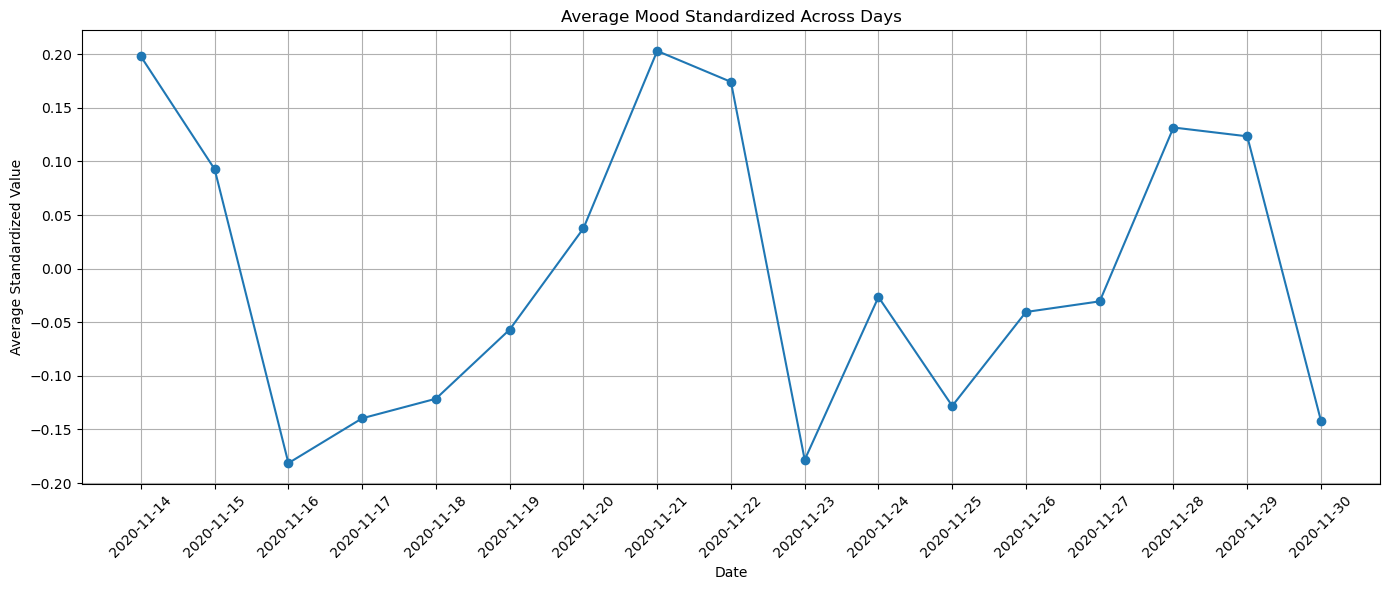

In [34]:
# Group the DataFrame by the 'date' variable and calculate the mean of 'expectday_standardized' and 'howwasday_standardized'
average_per_day = df.groupby('date')[['mood_standardized']].mean()

# Reset the index to make 'date' a column again (optional)
average_per_day.reset_index(inplace=True)

average_per_day['date'] = pd.to_datetime(average_per_day['date'])

plt.figure(figsize=(14, 6))
plt.plot(average_per_day['date'], average_per_day['mood_standardized'], label='Average Mood Standardized', marker='o')
plt.xlabel('Date')
plt.ylabel('Average Standardized Value')
plt.title('Average Mood Standardized Across Days')
plt.xticks(ticks=average_per_day['date'], labels=average_per_day['date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

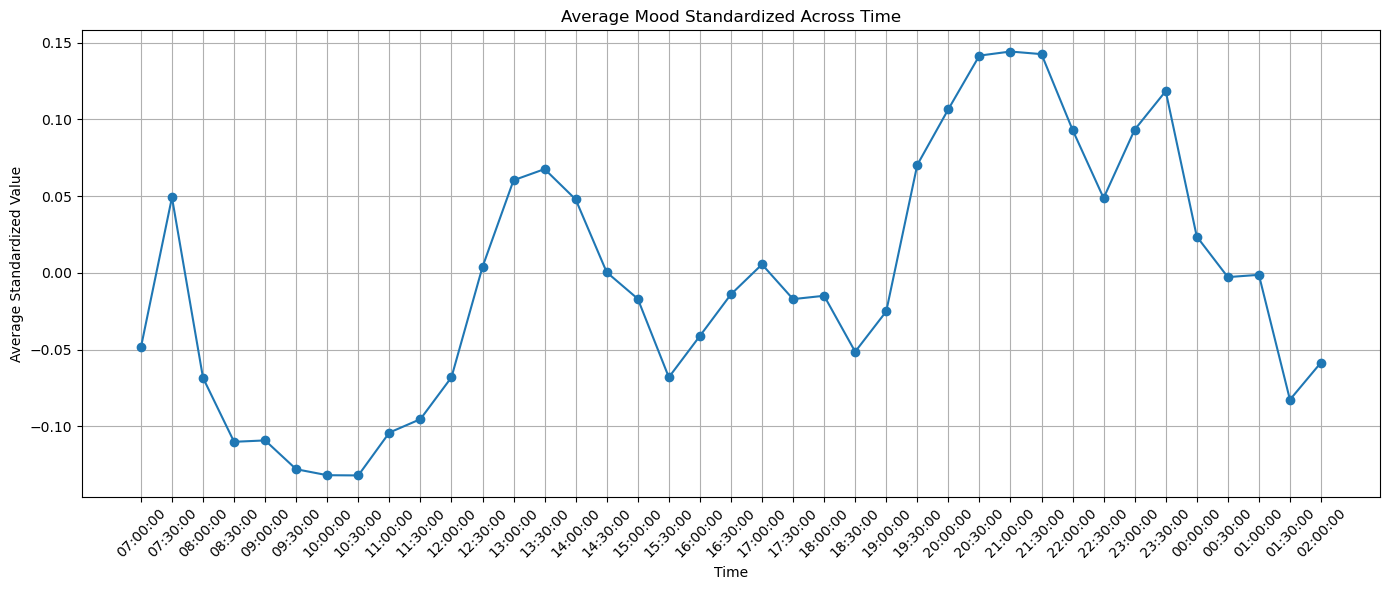

In [35]:
# Shift the time variable back by 5 hours
df['adjusted_time'] = (pd.to_datetime(df['time'], format='%H:%M:%S') - pd.Timedelta(hours=5)).dt.strftime('%H:%M:%S')

# Group the DataFrame by the 'adjusted_time' variable and calculate the mean of 'mood_standardized'
average_per_time = df.groupby('adjusted_time')[['mood_standardized']].mean()

# Reset the index to make 'adjusted_time' a column again
average_per_time.reset_index(inplace=True)

# Relabel the adjusted time to reflect the actual clock time (shifting forward for display)
adjusted_to_actual = {f"{h:02}:{m:02}:00": f"{(h + 5) % 24:02}:{m:02}:00" for h in range(24) for m in [0, 30]}
average_per_time['actual_time'] = average_per_time['adjusted_time'].map(adjusted_to_actual)

average_per_time = average_per_time.loc[~average_per_time['actual_time'].isin(
    ['02:30:00', '03:00:00','03:30:00','04:00:00','04:30:00','05:00:00','05:30:00','06:00:00','06:30:00'])]

# Plot the data
plt.figure(figsize=(14, 6))
plt.plot(average_per_time['actual_time'], average_per_time['mood_standardized'], label='Average Mood Standardized', marker='o')
plt.xlabel('Time')
plt.ylabel('Average Standardized Value')
plt.title('Average Mood Standardized Across Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

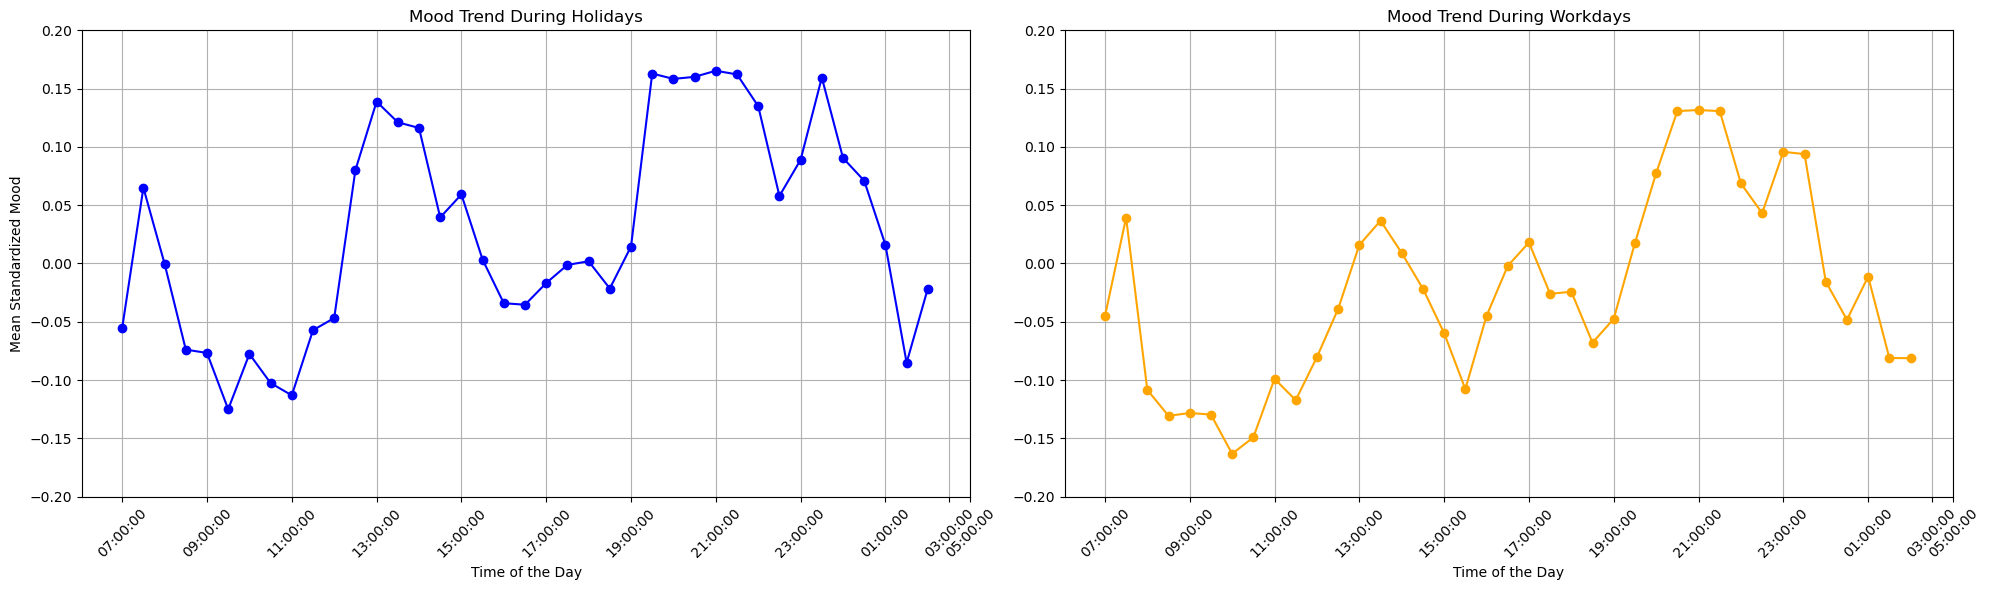

In [36]:
# Shift the time variable back by 5 hours
df['adjusted_half_hour'] = (pd.to_datetime(df['time'], format='%H:%M:%S') - pd.Timedelta(hours=5)).dt.strftime('%H:%M:%S')

# Filter data for holidays and workdays based on dummy variables
holiday_data = df[df['day_type_Holiday'] == 1]
workday_data = df[df['day_type_Workday'] == 1]

# Group by the adjusted time and calculate the mean of 'mood_standardized'
holiday_mood_trend = holiday_data.groupby('adjusted_half_hour')['mood_standardized'].mean().reset_index()
workday_mood_trend = workday_data.groupby('adjusted_half_hour')['mood_standardized'].mean().reset_index()

# Relabel the adjusted time to reflect the actual clock time (shifting forward for display)
adjusted_to_actual = {f"{h:02}:{m:02}:00": f"{(h + 5) % 24:02}:{m:02}:00" for h in range(24) for m in [0, 30]}
holiday_mood_trend['actual_time'] = holiday_mood_trend['adjusted_half_hour'].map(adjusted_to_actual)
workday_mood_trend['actual_time'] = workday_mood_trend['adjusted_half_hour'].map(adjusted_to_actual)

holiday_mood_trend = holiday_mood_trend.loc[~holiday_mood_trend['actual_time'].isin(
    ['02:30:00', '03:00:00','03:30:00','04:00:00','04:30:00','05:00:00','05:30:00','06:00:00','06:30:00'])]

workday_mood_trend = workday_mood_trend.loc[~workday_mood_trend['actual_time'].isin(
    ['02:30:00', '03:00:00','03:30:00','04:00:00','04:30:00','05:00:00','05:30:00','06:00:00','06:30:00'])]

# Define custom ticks for every two hours
custom_ticks = [f"{str(hour).zfill(2)}:00:00" for hour in range(1, 25, 2)]  # From 5:00 to 4:30

# Create subplots using plt
plt.figure(figsize=(20, 6))

# Plot for holidays
plt.subplot(1, 2, 1)
plt.plot(holiday_mood_trend['actual_time'], holiday_mood_trend['mood_standardized'], marker='o', color='blue')
plt.title('Mood Trend During Holidays')
plt.xlabel('Time of the Day')
plt.ylabel('Mean Standardized Mood')
plt.ylim(-0.2, 0.2)
plt.xticks(ticks=custom_ticks, rotation=45)  # Set custom ticks every two hours
plt.grid(True)

# Plot for workdays
plt.subplot(1, 2, 2)
plt.plot(workday_mood_trend['actual_time'], workday_mood_trend['mood_standardized'], marker='o', color='orange')
plt.title('Mood Trend During Workdays')
plt.xlabel('Time of the Day')
plt.ylim(-0.2, 0.2)
plt.xticks(ticks=custom_ticks, rotation=45)  # Set custom ticks every two hours
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

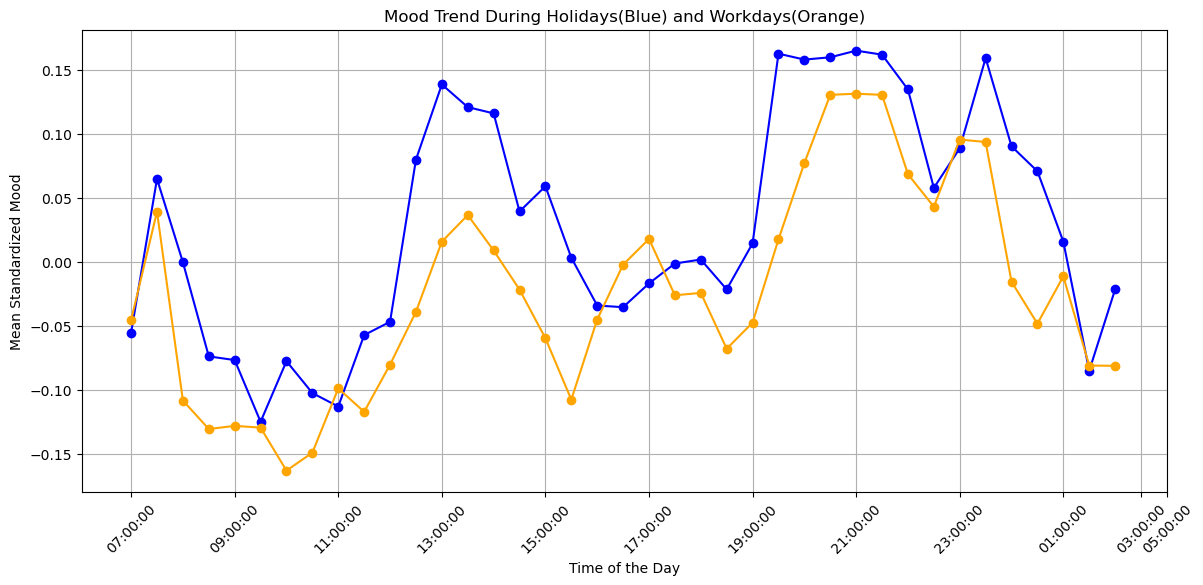

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(holiday_mood_trend['actual_time'], holiday_mood_trend['mood_standardized'], marker='o', color='blue')
plt.plot(workday_mood_trend['actual_time'], workday_mood_trend['mood_standardized'], marker='o', color='orange')
plt.title('Mood Trend During Holidays(Blue) and Workdays(Orange)')
plt.xlabel('Time of the Day')
plt.ylabel('Mean Standardized Mood')
plt.xticks(ticks=custom_ticks, rotation=45)  # Set custom ticks every two hours
plt.grid(True)

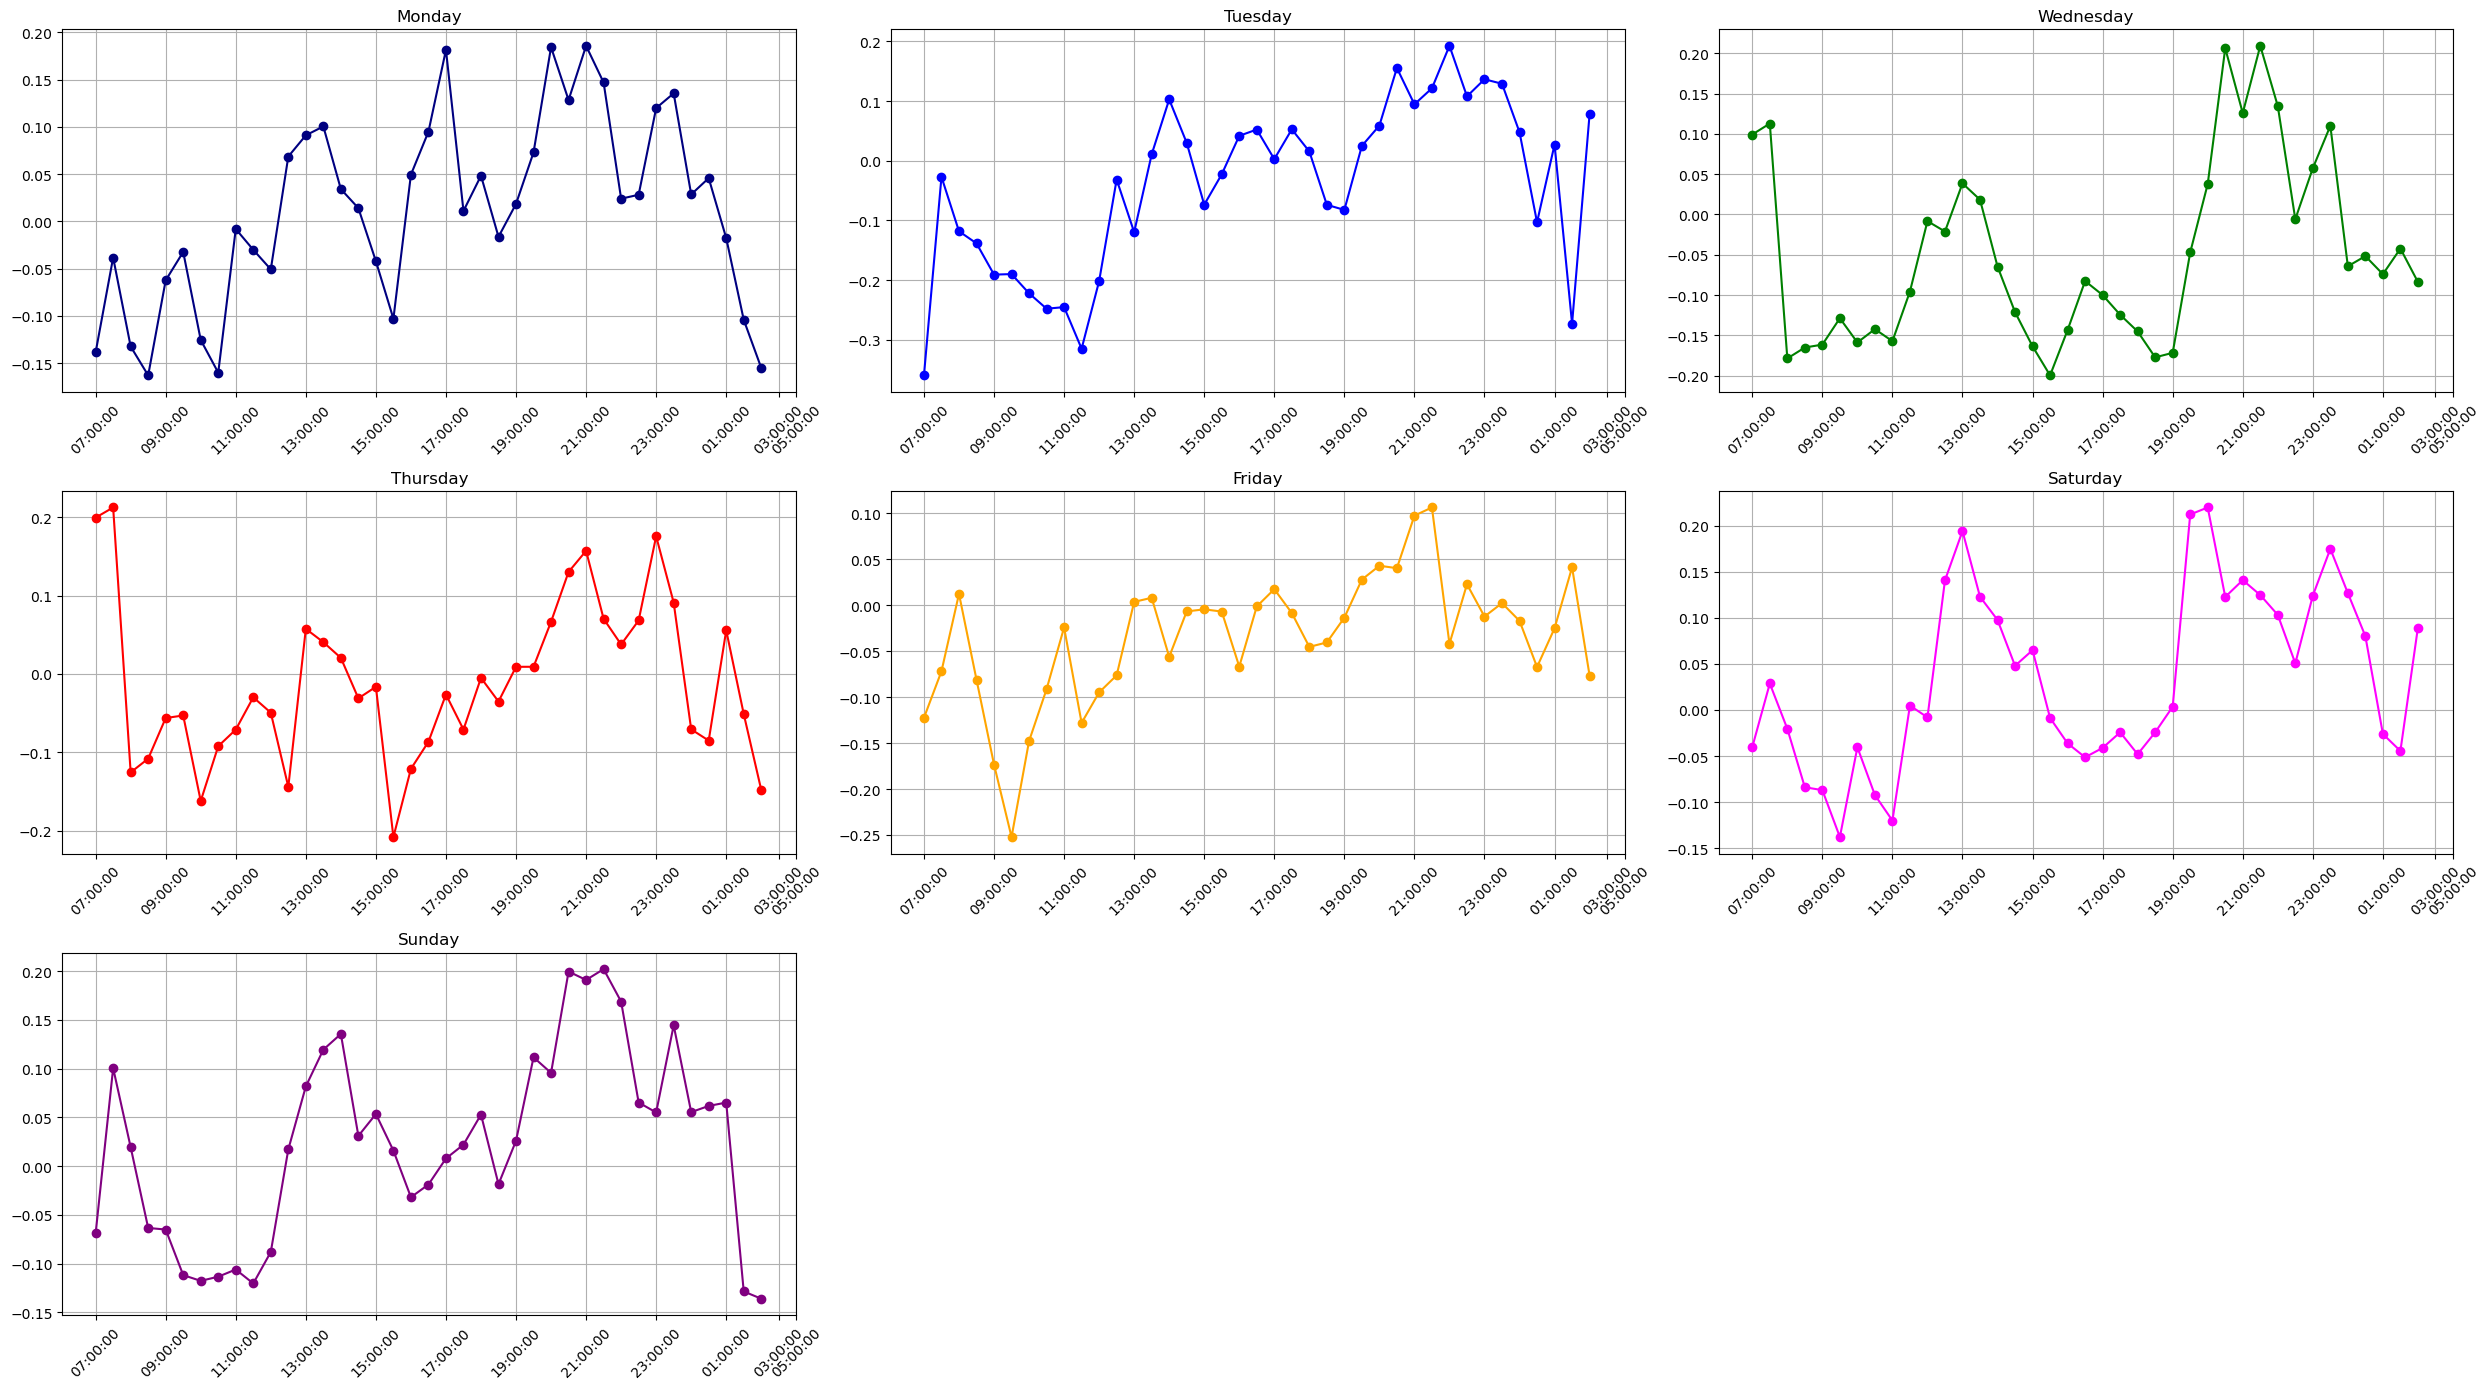

In [38]:
# Shift the time variable back by 5 hours
df['adjusted_half_hour'] = (pd.to_datetime(df['time'], format='%H:%M:%S') - pd.Timedelta(hours=5)).dt.strftime('%H:%M:%S')

# List of days and their corresponding dummy variables
days_of_week = {
    'Monday': 'day_of_week_Monday',
    'Tuesday': 'day_of_week_Tuesday',
    'Wednesday': 'day_of_week_Wednesday',
    'Thursday': 'day_of_week_Thursday',
    'Friday': 'day_of_week_Friday',
    'Saturday': 'day_of_week_Saturday',
    'Sunday': 'day_of_week_Sunday'
}

# Relabel the adjusted time to reflect the actual clock time (shifting forward for display)
adjusted_to_actual = {f"{h:02}:{m:02}:00": f"{(h + 5) % 24:02}:{m:02}:00" for h in range(24) for m in [0, 30]}

# Define custom ticks for every 3 hours in the adjusted time range
custom_ticks = [f"{str(hour).zfill(2)}:00:00" for hour in range(1, 25, 2)]  # From 5:00 to 4:30

# Create subplots for each day of the week
plt.figure(figsize=(25, 14))  # Adjust size to fit all subplots
num_days = len(days_of_week)
colors = ['navy', 'blue', 'green', 'red', 'orange', 'magenta', 'purple']

# Plot mood trend for each day of the week
for i, (day_name, day_var) in enumerate(days_of_week.items(), 1):
    # Filter data for the specific day using the dummy variable
    day_data = df[df[day_var] == 1]
    
    # Group by the adjusted time and calculate the mean of 'mood_standardized'
    day_mood_trend = day_data.groupby('adjusted_half_hour')['mood_standardized'].mean().reset_index()
    
    # Relabel adjusted time for proper display
    day_mood_trend['actual_time'] = day_mood_trend['adjusted_half_hour'].map(adjusted_to_actual)

    day_mood_trend = day_mood_trend.loc[~day_mood_trend['actual_time'].isin(
    ['02:30:00', '03:00:00','03:30:00','04:00:00','04:30:00','05:00:00','05:30:00','06:00:00','06:30:00'])]
    
    # Create a subplot for the current day
    plt.subplot(3, 3, i)  # Create a grid of subplots (3x3)
    plt.plot(day_mood_trend['actual_time'], day_mood_trend['mood_standardized'], marker='o', color=colors[i-1])
    plt.title(f'{day_name}')
    #plt.ylim(-0.29, 0.29)
    plt.xticks(custom_ticks, rotation=45)  # Set custom ticks for every 3 hours
    plt.grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [39]:
df.time.value_counts().tail(15)

08:00:00    560
01:00:00    344
07:30:00    260
01:30:00    225
02:00:00    160
07:00:00    144
02:30:00    122
03:00:00     84
06:30:00     66
03:30:00     63
04:00:00     43
04:30:00     39
06:00:00     37
05:00:00     34
05:30:00     30
Name: time, dtype: int64

In [40]:
# Define the columns to be one-hot encoded
categorical_columns = ['time']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)  # 'drop="first"' to avoid multicollinearity

# Fit and transform the categorical columns
encoded_array = encoder.fit_transform(df[categorical_columns])

# Convert the encoded array into a DataFrame
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the original DataFrame (excluding the original categorical columns) with the new encoded DataFrame
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)

# Check the result
print(df.columns)

c:\Users\39348\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Index(['id', 'datetime', 'date', 'date_adjusted', 'mood', 'Extraversion',
       'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness',
       ...
       'time_19:00:00', 'time_19:30:00', 'time_20:00:00', 'time_20:30:00',
       'time_21:00:00', 'time_21:30:00', 'time_22:00:00', 'time_22:30:00',
       'time_23:00:00', 'time_23:30:00'],
      dtype='object', length=156)


In [41]:
df = df.dropna()

df.isnull().sum().sum()

0

In [42]:
len(df)

43380

In [43]:
df.id.nunique()

98

In [44]:
df.id.value_counts()

66.0     541
126.0    536
119.0    533
3.0      529
163.0    528
        ... 
31.0     343
72.0     335
24.0     318
86.0     312
176.0    236
Name: id, Length: 98, dtype: int64

In [45]:
print(list(df.columns))

['id', 'datetime', 'date', 'date_adjusted', 'mood', 'Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 'Punivers', 'Pself', 'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen', 'Pselfenh', 'Pselftran', 'Pconserv', 'Pexcitements', 'Psuprapersonal', 'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic', 'Logicmath', 'Spatial', 'Bodykines', 'Musical', 'Interpersonal', 'Intrapersonal', 'Environmental', 'Spiritual', 'mood_numeric', 'mood_diff', 'mood_change', 'mood_standardized', 'what2_Cooking', 'what2_DistantCommunication/SeekingInternet', 'what2_Eating', 'what2_Householdcare/Shopping', 'what2_Lecture', 'what2_Leisure', 'what2_Listeningmusic/Reading', 'what2_Social media', 'what2_Sociallife/Happy Hour', 'what2_Study/workgroup', 'what2_Travel', 'what2_Watching/TV/YouTube', 'what2_Work/Other', 'withw2_Alone', 'withw2_Classmates', 'withw2_Colleagues/Other', 'withw2_Friends', 'withw2_Partner', 'wit

In [46]:
# Calculate VIF for each feature
X = df[['day_of_week_Friday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 
                    'day_of_week_Wednesday',
                    'time_00:00:00', 'time_00:30:00', 'time_01:00:00', 'time_01:30:00', 'time_02:00:00', 'time_07:30:00', 
                    'time_08:00:00', 'time_08:30:00', 'time_09:00:00', 'time_09:30:00', 'time_10:00:00', 'time_10:30:00', 'time_11:00:00', 
                    'time_11:30:00', 'time_12:00:00', 'time_12:30:00', 'time_13:00:00', 'time_13:30:00', 'time_14:00:00', 'time_14:30:00', 
                    'time_15:00:00', 'time_15:30:00', 'time_16:00:00', 'time_16:30:00', 'time_17:00:00', 'time_17:30:00', 'time_18:00:00', 
                    'time_18:30:00', 'time_19:00:00', 'time_19:30:00', 'time_20:00:00', 'time_20:30:00', 'time_21:00:00', 'time_21:30:00', 
                    'time_22:00:00', 'time_22:30:00', 'time_23:00:00', 'time_23:30:00']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

                 Variable       VIF
1    day_of_week_Saturday  2.267218
2      day_of_week_Sunday  2.247683
4     day_of_week_Tuesday  1.876715
3    day_of_week_Thursday  1.876222
0      day_of_week_Friday  1.873508
5   day_of_week_Wednesday  1.859438
22          time_13:00:00  1.202774
37          time_20:30:00  1.201412
36          time_20:00:00  1.201002
23          time_13:30:00  1.200392
35          time_19:30:00  1.198726
38          time_21:00:00  1.197490
21          time_12:30:00  1.197466
24          time_14:00:00  1.197385
31          time_17:30:00  1.197029
34          time_19:00:00  1.196946
30          time_17:00:00  1.196717
29          time_16:30:00  1.195659
39          time_21:30:00  1.195157
27          time_15:30:00  1.195073
19          time_11:30:00  1.194936
33          time_18:30:00  1.194015
40          time_22:00:00  1.193893
20          time_12:00:00  1.193694
28          time_16:00:00  1.193425
32          time_18:00:00  1.193316
26          time_15:00:00  1

In [47]:
# Calculate VIF for each feature
X = df[['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness', 'Pconformity', 'Ptradition', 'Pbenov', 
                    'Punivers', 'Pself', 'Pstim', 'Phedon', 'Pachieve', 'Ppower', 'Psecurity', 'Popen', 'Pselfenh', 'Pselftran', 'Pconserv', 
                    'Pexcitements', 'Psuprapersonal', 'Pinteractive', 'Ppromotion', 'Pexistence', 'Pnormative', 'Linguistic', 'Logicmath', 
                    'Spatial', 'Bodykines', 'Musical', 'Interpersonal', 'Intrapersonal', 'Environmental', 'Spiritual']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

             Variable       VIF
6          Ptradition  0.019526
4            Openness  0.016866
7              Pbenov  0.010496
22         Ppromotion  0.008193
21       Pinteractive  0.008157
11             Phedon  0.005087
16           Pselfenh  0.003379
25         Linguistic  0.002002
9               Pself  0.001914
23         Pexistence  0.001875
30      Interpersonal  0.001822
0        Extraversion  0.001772
28          Bodykines  0.001568
31      Intrapersonal  0.001066
13             Ppower  0.000548
2   Conscientiousness  0.000495
17          Pselftran  0.000493
27            Spatial  0.000308
29            Musical  0.000257
3         Neuroticism  0.000208
5         Pconformity  0.000133
12           Pachieve  0.000125
19       Pexcitements  0.000124
8            Punivers  0.000120
33          Spiritual  0.000096
26          Logicmath  0.000088
15              Popen  0.000086
14          Psecurity  0.000077
1       Agreeableness  0.000065
24         Pnormative  0.000062
18      

In [48]:
# Calculate VIF for each feature
X = df[['gender_Male', 'nationality_Foreign', 'department_Engineering and Applied Sciences', 'department_Humanities', 
                    'department_International Relations and Public Administration', 'department_Law', 
                    'department_Medicine and veterinary medicine', 'department_Natural Sciences', 'department_Social Sciences',
                    'cohort_19', 'cohort_20', 'cohort_21', 'cohort_22', 'cohort_23', 'cohort_24', 'cohort_25-26', 
                    'cohort_27-30', 'cohort_31+', 'degree_MSc', 'residence_Close to the university', 'residence_Far from the university', 
                    'residence_Rovereto']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

c:\Users\39348\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


                                             Variable       VIF
18                                         degree_MSc  4.913324
12                                          cohort_22  3.024841
14                                          cohort_24  3.011140
0                                         gender_Male  2.931997
2         department_Engineering and Applied Sciences  2.896000
13                                          cohort_23  2.755320
8                          department_Social Sciences  2.401322
7                         department_Natural Sciences  2.377717
5                                      department_Law  2.210384
15                                       cohort_25-26  2.169137
17                                         cohort_31+  2.130919
1                                 nationality_Foreign  1.995342
11                                          cohort_21  1.901277
9                                           cohort_19  1.736319
3                               departme

In [49]:
# Calculate VIF for each feature
X = df[['what2_DistantCommunication/SeekingInternet', 'what2_Eating', 'what2_Householdcare/Shopping', 'what2_Lecture', 'what2_Leisure', 'what2_Listeningmusic/Reading', 
                    'what2_Social media', 'what2_Sociallife/Happy Hour', 'what2_Study/workgroup', 'what2_Travel', 'what2_Watching/TV/YouTube', 
                    'what2_Work/Other', 'withw2_Classmates', 'withw2_Colleagues/Other', 'withw2_Friends', 'withw2_Partner', 
                    'withw2_Relatives', 'withw2_Roommates', 'where2_AnotherIndoor', 'where2_AnotherOutdoor', 'where2_Classroom/Uni_Library', 
                    'where2_House/friends/others', 'where2_RelativesHome']]
vif = pd.DataFrame({
    'Variable': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif.sort_values(by="VIF", ascending=False))

                                      Variable       VIF
19                       where2_AnotherOutdoor  2.057807
9                                 what2_Travel  1.989779
16                            withw2_Relatives  1.597299
18                        where2_AnotherIndoor  1.589605
22                        where2_RelativesHome  1.421310
21                 where2_House/friends/others  1.409821
15                              withw2_Partner  1.398751
13                     withw2_Colleagues/Other  1.384078
14                              withw2_Friends  1.367402
11                            what2_Work/Other  1.361380
7                  what2_Sociallife/Happy Hour  1.324692
1                                 what2_Eating  1.316798
20                where2_Classroom/Uni_Library  1.294262
12                           withw2_Classmates  1.291896
4                                what2_Leisure  1.182371
10                   what2_Watching/TV/YouTube  1.154848
8                        what2_

In [50]:
df.to_csv('C:/Users/39348/Downloads/data/df_dataset.csv', index=False)

In [51]:
df_workday.to_csv('C:/Users/39348/Downloads/data/df_workday_dataset.csv', index=False)

In [52]:
df_holiday.to_csv('C:/Users/39348/Downloads/data/df_holiday_dataset.csv', index=False)

In [186]:
pd.set_option('display.max_rows', None)

In [ ]:
pd.reset_option('display.max_rows')